In [28]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Pad
import os
import pickle
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets

from tqdm import tqdm
import seaborn as sns
from pathlib import Path

import preprocessing as pre
import visualize as vis
from models import LightningDiffusion as ld


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
data_path = "/data/cb/ruochiz/scHiC/"
data_names = ["m3c_mouse_brain_small",  "m3c_Tian_et_al", "m3C_hg38_M1C_old",  "m3c_human_pfc_old", "m3c_Heffel_et_al"]
selection = int(input("Pick dataset (1. Small Mouse Brain | 2. Tian et al): "))-1
data_name = data_names[selection]
dataset_path = os.path.join(data_path,data_name)

if selection ==0:
    config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/config_m3c_mouse_brain_small_1M.json")
    train_config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/train_configs/config_pseudobulk_smallmouse.json")
elif selection == 1:
    config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/config_m3c_Tian_HumanBrain_1M.JSON")
    train_config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/train_configs/config_pseudobulk_tianhumanbrain.json")
dataset_path
# dataset_hic_path = os.path.join(dataset_path,"contact_pairs_filter")

'/data/cb/ruochiz/scHiC/m3c_Tian_et_al'

In [20]:
all_maps = []

cell_numbers = range(1,143761)

ogpath = "/data/cb/mihirb14/projects/Daifuku/data/m3c_Tian_et_al/contactmaps_1M/bulk/"
for i in tqdm(cell_numbers):
    all_maps.append(np.load(os.path.join(ogpath,f"chr10_cell{i}_pseudobulk.npy")))
    
save = np.stack(all_maps,axis=0)
np.save(os.path.join(ogpath,f"aggregated/chr10.npy"),save)
save.shape

# with open(os.path.join(dataset_path, "filelist.txt")) as f:
#     lines = f.readlines()
# for i, line in enumerate(lines):
#     filename = line.split("/")[-1]
#     lines[i] = dataset_path+"/"+filename
# with open("/data/cb/mihirb14/projects/Daifuku/data/m3c_Tian_et_al/filelist.txt", 'w') as f2:
#     f2.writelines(lines)


100%|██████████| 143760/143760 [01:13<00:00, 1947.14it/s]


(143760, 134, 134)

In [17]:
np.stack([np.ones((3,3)),np.zeros((3,3))],axis=0).shape

(2, 3, 3)

In [8]:
# example_contact = np.load("/data/cb/mihirb14/projects/Daifuku/data/mc3_mouse_brain_small/contactmaps/raw/chr1_sparse_adj.npy",allow_pickle=True)
# print(example_contact.shape, example_contact[0].shape)
# contact_map = pre.spy_sparse2torch_sparse(example_contact[0]).to_dense()
# # px.imshow(contact_map,  color_continuous_scale='deep_r')

tian_data_info = pd.DataFrame(np.load("../data/m3c_Tian_et_al/label_info.pickle", allow_pickle=True), index=None)
print(len(np.unique(tian_data_info["Donor_Region"])))
tian_data_info

50


,Unnamed: 0,PassFilter,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,pool,Plate,plate_relative_read,Donor,Region,tech,SubType,MajorType,CellClass,Donor_Region
0,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A1,True,0.006068,0.773828,0.012215,2116936,hba_m3c16_h1930002_BNST,HBA_220218_H1930002_CX47_BNST_3C_1_P1,0.971324,h1930002,BNST,snm3C-seq,ASC_0,ASC,Non-neuronal Cells,h1930002_BNST
1,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A13,True,0.004877,0.769910,0.011441,2250650,hba_m3c16_h1930002_BNST,HBA_220218_H1930002_CX47_BNST_3C_1_P1,1.032676,h1930002,BNST,snm3C-seq,MSN_D1_0,MSN-D1,Inhibitory/non-telencephalic neurons,h1930002_BNST
2,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A14,True,0.005228,0.745918,0.006356,2655450,hba_m3c16_h1930002_BNST,HBA_220218_H1930002_CX47_BNST_3C_1_P1,1.218413,h1930002,BNST,snm3C-seq,OPC_0,OPC,Non-neuronal Cells,h1930002_BNST
3,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-A2,True,0.008819,0.750491,0.013308,2365072,hba_m3c16_h1930002_BNST,HBA_220218_H1930002_CX47_BNST_3C_1_P1,1.085177,h1930002,BNST,snm3C-seq,ODC_0,ODC,Non-neuronal Cells,h1930002_BNST
4,HBA_220218_H1930002_CX47_BNST_3C_1_P1-1-M14-B1,True,0.005061,0.761122,0.016676,779910,hba_m3c16_h1930002_BNST,HBA_220218_H1930002_CX47_BNST_3C_1_P1,0.357850,h1930002,BNST,snm3C-seq,Bergmann-glia,ASC,Non-neuronal Cells,h1930002_BNST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143755,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-O24,True,0.010842,0.798236,0.054124,1948656,hba_m3c11_h1930002_FI,HBA_211117_H1930002_CX47_FI_3C_1_P8,0.984126,h1930002,FI,snm3C-seq,Sncg_1,Sncg,Inhibitory/non-telencephalic neurons,h1930002_FI
143756,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P11,True,0.012916,0.768051,0.062617,2450246,hba_m3c11_h1930002_FI,HBA_211117_H1930002_CX47_FI_3C_1_P8,1.237444,h1930002,FI,snm3C-seq,L6_IT_Car3_1,L6-IT-Car3,Telencephalic excitatory neurons,h1930002_FI
143757,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P12,True,0.006666,0.801151,0.026621,2906150,hba_m3c11_h1930002_FI,HBA_211117_H1930002_CX47_FI_3C_1_P8,1.467688,h1930002,FI,snm3C-seq,Vip_4,Vip,Inhibitory/non-telencephalic neurons,h1930002_FI
143758,HBA_211117_H1930002_CX47_FI_3C_1_P8-6-J7-P23,True,0.008189,0.792329,0.036346,2293534,hba_m3c11_h1930002_FI,HBA_211117_H1930002_CX47_FI_3C_1_P8,1.158300,h1930002,FI,snm3C-seq,Sncg_0,Sncg,Inhibitory/non-telencephalic neurons,h1930002_FI


In [42]:
# config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/config_m3c_Tian_HumanBrain_1M.JSON")
# train_config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/train_configs/config_pseudobulk_tianhumanbrain.json")
train_config["normalization"] = "none"
config["train_config"] = train_config

def generate_pseudobulk(config):
    num_cells_pseudobulk = config["num_cells_pseudobulk"]
    contact_map_path = config["temp_dir"]
    chrom_list = config['chrom_list']
    data_info = pd.DataFrame(np.load(config["data_dir"]+"label_info.pickle", allow_pickle=True), index=None)

        
    unpack_path = os.path.join(contact_map_path,"bulk")
    print("Destination: "+unpack_path)
    if not os.path.exists(unpack_path):
        os.mkdir(unpack_path)
        
    higashi_embed_dir = config["higashi_embed_dir"]
    if os.path.exists(higashi_embed_dir):
        higashi_embeddings = np.load(os.path.join(higashi_embed_dir,"embedding.npy"), allow_pickle=True)
        indices = get_knn(higashi_embeddings, k=num_cells_pseudobulk)

        for chrom in tqdm(chrom_list, desc="Generating pseudobulk contact maps"):
            chrom_contact_maps = np.load(f"{contact_map_path}/raw/{chrom}_sparse_adj.npy", allow_pickle=True) # load contact maps for chromosome at index chrom_idx
            chrom_contact_maps = chrom_contact_maps[indices]
            for i, neighbors in enumerate(chrom_contact_maps):
                pseudobulk_map = np.mean(np.array([sparse_map.todense() for sparse_map in neighbors]), axis=0)
                map_path = os.path.join(unpack_path, chrom+"_cell"+str(i+1)+"_pseudobulk.npy")
                np.save(map_path,pseudobulk_map)
    else:
        for cell_i, row in  tqdm(data_info[:50].iterrows(), desc=f"Generating pseudobulk contact maps"):
            cell_i_subtype = row["SubType"]
            cell_i_donor_region = row["Donor_Region"]
            cell_i_candidate_neighbors_region_indices = set(data_info.index[(data_info['Donor_Region'] == cell_i_donor_region)])
            cell_i_candidate_neighbors_subtype_indices = set(data_info.index[(data_info['SubType'] == cell_i_subtype)])
            intersection = np.array(list(cell_i_candidate_neighbors_region_indices.intersection(cell_i_candidate_neighbors_subtype_indices)))
            if len(intersection) < config["num_cells_pseudobulk"]:
                remaining_sampled_from_subtype = np.random.choice(np.array(list(cell_i_candidate_neighbors_region_indices)), config["num_cells_pseudobulk"] - len(intersection), replace=False)
                cell_i_neighbor_indices = np.concatenate([intersection,remaining_sampled_from_subtype])
                print(cell_i_neighbor_indices)
            else:
                sampled_from_intersection = np.random.choice(intersection, config["num_cells_pseudobulk"], replace=False)
                cell_i_neighbor_indices = sampled_from_intersection

            for chrom in chrom_list:
                chrom_contact_maps = np.load(f"{contact_map_path}/raw/{chrom}_sparse_adj.npy", allow_pickle=True) # load contact maps for chromosome at index chrom_idx
                chrom_contact_maps = chrom_contact_maps[cell_i_neighbor_indices]
                pseudobulk_map = np.mean(np.array([sparse_map.todense() for sparse_map in neighbors]), axis=0)
                map_path = os.path.join(unpack_path, chrom+"_cell"+str(i+1)+"_pseudobulk.npy")
                np.save(map_path,pseudobulk_map)


    return lengths

lengths = generate_pseudobulk(config)

Destination: /data/cb/mihirb14/projects/Daifuku/data/m3c_Tian_et_al/contactmaps_1M/bulk


Generating pseudobulk contact maps: 5it [00:00, 43.16it/s]

[   4  871  263  332 2528  312 1677  365 2150 2382 2233 2922 2251  311
  285 2864 2720 1330 1333 2727  102  801 1026 1032 1188 1441 1517 1872
 2552 2561 1987 2680 1692 1533 2409   75  775  235 1821 2385 1459 1605
 1250  232 2130 1054  573 1826 1307 2702]
[1027  644    5 1287  657 2066 2710  665 1434  668 1821 1787  288 1057
 2470 1705 1450 1963 2732 2481  693 2230  825 2108 1213 2496 2250 2890
 1610 2256 2011 2527 1503  225 1634 1124  618 2029 1134 1776 2297 1019
  772 1754 2840 1049 1093  892 2849 2260]


Generating pseudobulk contact maps: 20it [00:00, 44.23it/s]

[ 382  771 1541 2823  142   15 1423 2453  150 1058 1444 2854  170 1454
 1199  181 2631 2517 2916 1129 1391 2031  497 1522 1653 1654 2682  251
 1022 1183   19  475  145 1056  217 1094 1226 2717 1052  635  882  158
 2279  666  184  647 1840  394 1968  690]
[2184  649 2824 1555 2836   21 1684 2199 1442 1955  677  814 1839 1967
 1079 1209 2879 1241 2523 2016   97 1889 2917 1382  359 1641 1261 2291
  500 1399 2171  636 1917 2174 2689 1852 2369 2138  808 1739 2717 1742
 2818 2158  484  531  863 2562 1167 1398]


Generating pseudobulk contact maps: 50it [00:01, 44.06it/s]

[1473 1762 1989   42 2125  944  529 1307 1689 2331 2687 2383 2003 1361
 1534 1019 2748 1146  815 1548 1195  717  535 2632 2420 1358 1064 2817
 2419  244 1296  196 1443 2610  734  248 2216 1553  461  871 2032 1876
  297 1245 2844 1604 1045 1413 2203 1491]


In [39]:
(np.array(lengths)<50).sum()

# pseudobulk_path = config["temp_dir"] + "bulk/"
# length = len(small_mouse_hic_dataloader)

# pseudobulk_map = np.zeros(shape=(196,196))
# for i, map in enumerate(small_mouse_hic_dataloader):
#     if i%20 == 0 and i!=0:
#         np.save(os.path.join(pseudobulk_path,str(math.ceil(i/20))), pseudobulk_map/20)
#         pseudobulk_map = np.zeros(shape=(196,196))
#     pseudobulk_map += map.numpy().squeeze()

5

In [30]:
train_config["normalization"] = "none"
config["train_config"] = train_config
sc_hic_dataset = pre.ScHiCDataset(config)
sc_hic_dataloader = DataLoader(sc_hic_dataset, batch_size=1)
bulk_hic_dataset = pre.BulkHiCDataset(config=config)
bulk_hic_dataloader = DataLoader(bulk_hic_dataset, batch_size=1)

len(bulk_hic_dataset)

143760

In [31]:
chrom1_cell1_map = next(iter(sc_hic_dataloader))
print(chrom1_cell1_map.shape)
vis.visualize_contact_map(chrom1_cell1_map.squeeze(),zmax=1)

torch.Size([1, 136, 136])


In [32]:
pseudobulk_1_map = next(iter(bulk_hic_dataloader)) # make sure to check that the config file has "none" in the normalization when testing this.

# Normalization
diagonal_norm_pseudobulk_1_map = pre.diagonal_normalize(pseudobulk_1_map.squeeze())
zero_one_norm_pseudobulk_1_map  = pre.zero_one_normalize(diagonal_norm_pseudobulk_1_map)
# print(pseudobulk_1_map.shape)


# Unnormalization
zero_one_unnorm_pseudobulk_1_map = pre.zero_one_unnormalize(zero_one_norm_pseudobulk_1_map,diagonal_norm_pseudobulk_1_map.squeeze() )
diagonal_unnorm_pseudobulk_1_map = pre.diagonal_unnormalize(zero_one_unnorm_pseudobulk_1_map,pseudobulk_1_map.squeeze() )

original_reconstructed = diagonal_unnorm_pseudobulk_1_map

# Display

normalization_display = [vis.visualize_contact_map(pseudobulk_1_map, zmax=1, title="Unnormalized (starting map)"),vis.visualize_contact_map(diagonal_norm_pseudobulk_1_map, zmax=None, title="Diagonal Normalized"),vis.visualize_contact_map(zero_one_norm_pseudobulk_1_map, zmax=1, title="01 Normalized")]
unnormalization_display= [vis.visualize_contact_map(zero_one_norm_pseudobulk_1_map, zmax=1, title="Normalized"), vis.visualize_contact_map(zero_one_unnorm_pseudobulk_1_map, zmax=None, title="01 Unnormalized"),vis.visualize_contact_map(diagonal_unnorm_pseudobulk_1_map, zmax=1, title="Diagonal Unnormalized (Reconstructed OG)")]


display(vis.visualize_multiple_jupyter(normalization_display))
display(vis.visualize_multiple_jupyter(unnormalization_display))


print(f"Reconstruction error after normalization/unnormalization: {(original_reconstructed - pseudobulk_1_map.detach().numpy().squeeze()).sum()}")


    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<…

    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<…

Reconstruction error after normalization/unnormalization: -0.0005834177136421204


In [33]:

daifuku = ld.LightningDiffusion(train_config=train_config)

# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1M_500epochs.ckpt")
# checkpoint = torch.load("../Daifuku/lmbg9mze/checkpoints/epoch=499-step=8500.ckpt")
# checkpoint = torch.load("../Daifuku/g9hx58dz/checkpoints/epoch=1999-step=90000.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimg_2000epochs.ckpt")
# checkpoint = torch.load("../Daifuku/9q6c4m2f/checkpoints/epoch=876-step=12278.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimgzscore_900epochs.ckpt") # good
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mprednoisezscore_650epochs.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimgdiagonal_1000epochs.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimgdiagonalneg1to1_1000epochs.ckpt")
checkpoint = torch.load("../out/trained/daifuku_bulktianhumanbrain1Mpredimgdiagonalneg1to1_60epochs.ckpt")

daifuku.load_state_dict(checkpoint['state_dict'])
daifuku.eval()
print(train_config["sampling_timesteps"])

1000


In [34]:
imgs, imgs_unnorm, starts_norm, starts_unnorm = daifuku.sample(5, return_all_timesteps=True)
starts_unnorm.shape

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([5, 1000, 1, 136, 136])

In [53]:

unnormalized_samples_figs = []

sample_step = 999

for i in range(imgs_unnorm.shape[0]-1):
    sampled = imgs_unnorm.squeeze()[i].detach().numpy()[sample_step]
    zero_one_unnorm_sample = pre.zero_one_unnormalize(sampled, diagonal_norm_pseudobulk_1_map.squeeze())
    diagonal_unnorm_sample = pre.diagonal_unnormalize(zero_one_unnorm_sample, pseudobulk_1_map.detach().numpy().squeeze())
    unnormalized_samples_figs.append(vis.visualize_contact_map(diagonal_unnorm_sample, zmax=1, title=f"Sample {i+1}"))

display(vis.visualize_multiple_jupyter(unnormalized_samples_figs))

differences1=imgs_unnorm.squeeze()[0].detach().numpy()[sample_step] - imgs_unnorm.squeeze()[1].detach().numpy()[sample_step]
differences2=imgs_unnorm.squeeze()[0].detach().numpy()[sample_step] - zero_one_norm_pseudobulk_1_map
differences_fig = [vis.visualize_contact_map(differences1, zmax=None, title="Difference between Sample 1 and 2"), vis.visualize_contact_map(differences2, zmax=None, title="Difference between Sample 1 and Real Sample")]
display((vis.visualize_multiple_jupyter( differences_fig)))

    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<…

    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<…

In [49]:
iterable_loader = iter(bulk_hic_dataloader)
count = 0
real_bulk_maps = []
real_bulk_maps_visualized = []
while count <4:
    real_bulk_maps_visualized.append(vis.visualize_contact_map(next(iterable_loader),zmax=1,title=f"Real Map {count+1}"))
    count+=1
    
display(vis.visualize_multiple_jupyter(real_bulk_maps_visualized))


    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<…

In [25]:
%pip install -U kaleido
path = "../out/visualized/animation/"
maps = imgs.squeeze().detach().numpy()
# maps = imgs_unnorm.squeeze().detach().numpy()
for i in range(999):
    sampled = maps[i]
    # zero_one_unnorm_sample = pre.zero_one_unnormalize(sampled, diagonal_norm_pseudobulk_1_map.squeeze())
    # sampled = pre.diagonal_unnormalize(zero_one_unnorm_sample, pseudobulk_1_map.detach().numpy().squeeze())
    fig = vis.visualize_contact_map(sampled,zmax=1)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,)
    fig.update_coloraxes(showscale=False)
    fig.write_image(f"../out/visualized/animation/fig{i}.png")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [26]:
import imageio

animated = [] 

for i in range(0,1000,20):
    animated.append(imageio.imread(f"../out/visualized/animation/fig{i}.png"))
    
imageio.mimsave('../out/visualized/animated.gif', animated)


/tmp/ipykernel_82517/2993371255.py:6: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



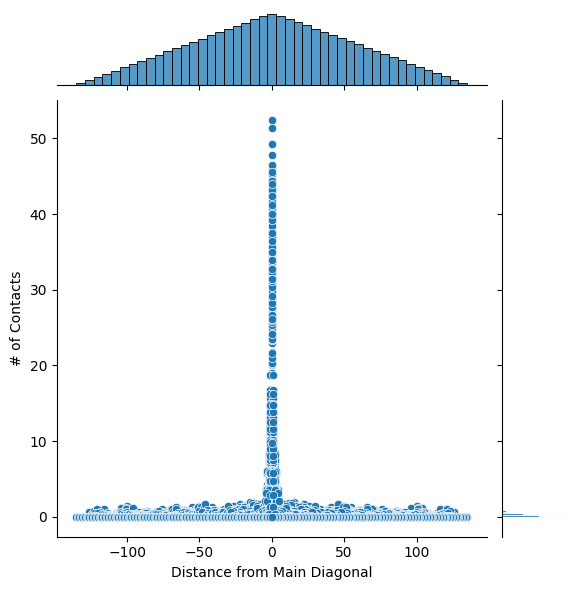

In [21]:
import plotly.figure_factory as ff

def plot_dist_vs_intensity(map):
    distances = []
    intensities = []
    for i in range(len(map)):
        for j in range(len(map[0])):
            # if i > j:
            #     distances.append(i-j)
            # else:
            distances.append(i-j)
            intensities.append(map[i][j])
    df = pd.DataFrame({"Distance from Main Diagonal":distances,"# of Contacts":intensities})
    fig = sns.jointplot(data=df, x="Distance from Main Diagonal", y="# of Contacts")
    return fig
            
plot_dist_vs_intensity(pseudobulk_1_map.detach().numpy().squeeze())